# Sensibility analysis BATS


In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from SALib import ProblemSpec
from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import (
    EnvironmentParameter,
    ForcingParameters,
    FunctionalGroups,
    KernelParameters,
    NoTransportParameters,
)
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.logging.custom_logger import set_error
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

set_error()

In [2]:
SAMPLE_NUMBER = 128

In [3]:
# path_forcing = "/Users/ash/Documents/Workspaces/Data/phd/CMEMS/bat_position/cmems_mod_glo_bgc_0_083deg.zarr"
path_forcing = "../../1_data_processing/1_1_Forcing/papa_cmems.zarr"

forcing = xr.open_zarr(path_forcing)
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
# forcing = forcing.cf.sel(Y=[31.6], X=[-64.2], method="nearest").sel(time=slice("2010", "2012"))
forcing.load()

<xarray.Dataset> Size: 1MB
Dimensions:              (time: 8095, depth: 3, latitude: 1, longitude: 1)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) int64 8B 50
  * longitude            (longitude) int64 8B -145
  * time                 (time) datetime64[ns] 65kB 1998-01-01 ... 2020-02-29
Data variables: (12/13)
    T                    (time, depth, latitude, longitude) float64 194kB 6.2...
    U                    (time, depth, latitude, longitude) float64 194kB 0.0...
    V                    (time, depth, latitude, longitude) float64 194kB 0.0...
    mnkc_epi             (time, latitude, longitude) float64 65kB 1.835 ... 2...
    mnkc_hmlmeso         (time, latitude, longitude) float64 65kB 2.382 ... 3...
    mnkc_lmeso           (time, latitude, longitude) float64 65kB 2.842 ... 3...
    ...                   ...
    mnkc_mumeso          (time, latitude, longitude) float64 65kB 2.779 ... 4...
    mnkc_umeso           (time, latitude, longitude) float64 65kB 1.68 ... 2.135
    npp                  (time, latitude, longitude) float64 65kB 105.8 ... 2...
    pelagic_layer_depth  (time, depth, latitude, longitude) float64 194kB 86....
    zeu                  (time, latitude, longitude) float64 65kB 57.33 ... 6...
    zooc                 (time, latitude, longitude) float64 65kB 1.618 ... 2...
Attributes: (12/13)
    Conventions:                      CF-1.7
    date_field:                       1998-01-01
    domain:                           global
    history:                          Created on 2022-09-28
    institution:                      CLS
    net_primary_production_model:     VGPM
    ...                               ...
    source:                           SEAPODYM-LMTL 3.0.0
    source_biogeochemical_variables:  OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS...
    source_physical_variables:        GLOBAL_REANALYSIS_PHY_001_030 CMEMS pro...
    spatial_resolution:               0.083x0.083
    temporal_resolution:              1 day
    title:                            Global ocean low and mid trophic levels...

In [4]:
forcing_parameter = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["npp"], resolution=0.08333, timestep=1),
    initial_condition_biomass=None,
    initial_condition_production=None,
)

## Generate initial solution


In [5]:
f_groups = FunctionalGroups(
    functional_groups=[
        FunctionalGroupUnit(
            name="D1N1",
            migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=1, night_layer=1),
            functional_type=FunctionalGroupUnitRelationParameters(
                inv_lambda_max=150,
                inv_lambda_rate=0.15,
                temperature_recruitment_rate=-0.11,
                cohorts_timesteps=[1] * np.ceil(10.38).astype(int),
                temperature_recruitment_max=10.38,
            ),
            energy_transfert=0.1668,
        )
    ]
)

parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=forcing_parameter,
    kernel_parameters=KernelParameters(compute_initial_conditions=True),
)
model_init = NoTransportModel(configuration=NoTransportConfiguration(parameters))

In [6]:
model_init.run()

In [7]:
twin_observation = model_init.export_biomass()
twin_observation = model_init.export_biomass().pint.quantify().pint.to("mg / meter ** 2").pint.dequantify()
twin_observation = twin_observation[0, :, 0, 0].rename("observations")

## Sensibility


In [8]:
def zoo_model_factory(
    forcing_parameter: ForcingParameters,
    day_layer: float = 1,
    night_layer: float = 1,
    tr_max: float = 10.38,
    tr_rate: float = -0.11,
    inv_lambda_max: float = 150,
    inv_lambda_rate: float = 0.15,
    energy_transfert: float = 0.1668,
):
    f_groups = FunctionalGroups(
        functional_groups=[
            FunctionalGroupUnit(
                name=f"D{day_layer}N{night_layer}",
                migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=day_layer, night_layer=night_layer),
                functional_type=FunctionalGroupUnitRelationParameters(
                    inv_lambda_max=inv_lambda_max,
                    inv_lambda_rate=inv_lambda_rate,
                    temperature_recruitment_rate=tr_rate,
                    cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
                    temperature_recruitment_max=tr_max,
                ),
                energy_transfert=energy_transfert,
            )
        ]
    )

    parameters = NoTransportParameters(functional_groups_parameters=f_groups, forcing_parameters=forcing_parameter)
    return NoTransportModel(configuration=NoTransportConfiguration(parameters))

In [11]:
def wrapper_zoo_model(x: np.ndarray):
    energy_transfert, tr_max, tr_rate, inv_lambda_max, inv_lambda_rate = x.T

    # Then call the original model
    model = zoo_model_factory(
        forcing_parameter=forcing_parameter,
        energy_transfert=energy_transfert,
        tr_max=tr_max,
        tr_rate=tr_rate,
        inv_lambda_max=inv_lambda_max,
        inv_lambda_rate=inv_lambda_rate,
    )
    model.run()
    biomass_pred = model.export_biomass().pint.quantify().pint.to("mg / meter ** 2").pint.dequantify()
    biomass_pred = biomass_pred[0, :, 0, 0].rename("prediction")
    return float(xr.corr(twin_observation, biomass_pred, dim="time"))

In [17]:
wrapper_zoo_model(np.array([0.1668, 10.38, -0.11, 150, 0.15]))

1.0

In [18]:
sp = ProblemSpec(
    {
        "names": [
            "energy_transfert",
            "tr_max",
            "tr_rate",
            "inv_lambda_max",
            "inv_lambda_rate",
        ],
        "groups": None,
        "bounds": [
            [0, 1],
            [0, 50],
            [-1, 0],
            [0, 1000],
            [0, 1],
        ],
        "outputs": ["Y"],
    }
)

# Mean biomasse value


In [19]:
param_values = sp.sample_sobol(SAMPLE_NUMBER)
Y = np.zeros([param_values.samples.shape[0]])
for i, X in enumerate(param_values.samples):
    Y[i] = wrapper_zoo_model(X)

# Provide the results to the interface
sp.set_results(Y)

Samples:
	5 parameters: ['energy_transfert', 'tr_max', 'tr_rate', 'inv_lambda_max', 'inv_lambda_rate']
	1536 samples
Outputs:
	1 outputs: ['Y']
	1536 evaluations


In [20]:
sp.analyze_sobol()
total_Si, first_Si, second_Si = sp.to_df()

<Figure size 640x480 with 0 Axes>

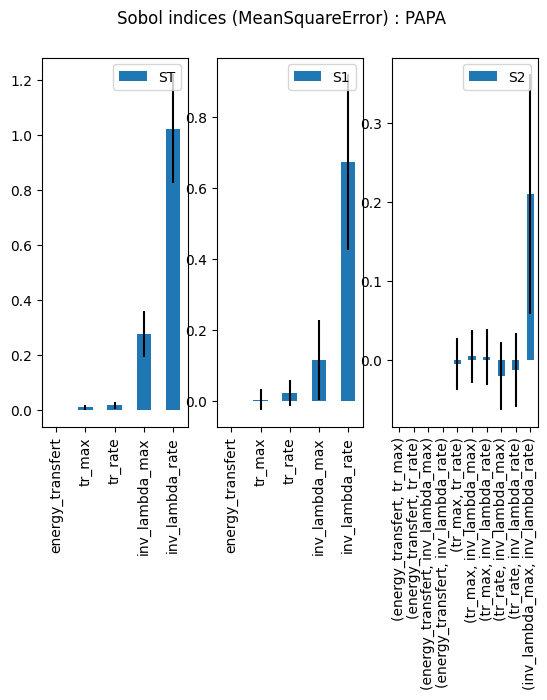

In [21]:
plt.figure()
ax = sp.plot()
plt.suptitle("Sobol indices (MeanSquareError) : PAPA")
plt.show()

<Axes: title={'center': 'Sobol indices (MeanSquareError) : PAPA'}>

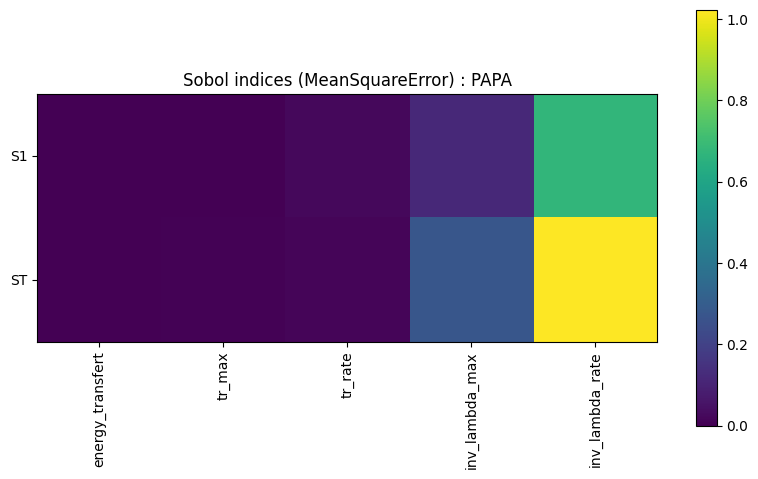

In [22]:
sp.heatmap(title="Sobol indices (MeanSquareError) : PAPA")